#### Goal: Reconstruct 2-D Gaussian sources from an incomplete Fourier space

In [1]:
import numpy as np
import numpy.fft as Discrete_Fourier_Transform
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns

In [2]:
'''
    Generic gaussian funciton creating a 2D gaussian distribution centered at (x_0, y_0) with a standard deviation sigma, and peak intensity
        f(x,y) = I * e^(- ( (x-x_0)^2 + (y-y_0)^2 ) / (2*sigma)^2 )
    Name:       gaussian_function()
    Parameters: 
                x_0: gaussain center x value
                y_0: gaussain center y value
                x: x coordiante grid
                y: y coordinate grid
                sigma: standard deviation of the gaussian
                intesity: gaussian peak intensity     
    Returns:
                2D array representing gaussian distribution

'''
def gaussain_function(x_0, y_0, x, y, sigma, intensity):
    return intensity * np.exp(-((x - x_0)**2 + (y - y_0)**2) / (2 * sigma**2)) 

In [3]:
'''
    Generate gaussian sources on a given grid size 
    Name:       generate_gaussian_sources()
    Parameters: 
                num_sources: number of gaussian sources to generate 
                grid_size: size of grid to generate the sources
                sigma_range: range of standard deviations for the gaussians
                intesity_range: range of intensity for the gaussains     
    Returns:
                sources: an array of 2D gaussian sources
'''
def generate_gaussian_sources(num_sources, grid_size, sigma_range, intensity_range):
    # All gaussian source list
    sources = []

    # Create all the gaussian souces
    for _ in range(num_sources):
        # Create initial variables
        x_0 = grid_size/2
        y_0 = grid_size/2
        sigma = np.random.randint(*sigma_range) # unpack sigma range
        intensity= np.random.randint(*intensity_range) # unpack intesity range

        # Create x and y space
        x = np.arange(0, grid_size, 1)
        y = np.arange(0, grid_size, 1)
        x, y = np.meshgrid(x, y)

        # Gaussian function
        curr_source = gaussain_function(x_0, y_0, x, y, sigma, intensity)
        sources.append(curr_source)

    return np.array(sources)


In [4]:
'''
    Compute the fourier transform of the 2D gaussian sources to convert them to the frequency domain
    (if the gaussian is wide -> decrease width, if the gaussian is narrow -> increase width)
    Name:       apply_fourier_transform()
    Parameters: 
                sources: array of 2D gaussian sources    
    Returns:
                magnitude: magnitude of the fourier transformed sources
                phase: phase of the fourier transformed sources
'''
def apply_fourier_transform(sources):
    # Shift the zero-frequency component to the center of the gaussian (https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html)
    fourier_transformed = Discrete_Fourier_Transform.fftshift(Discrete_Fourier_Transform.fft2(sources), axes=(-2, -1)) 

    # Compute magnitude and phase of transform
    magnitude = np.abs(fourier_transformed)
    phase = np.angle(fourier_transformed)

    # Make the fourier data
    fourier_data = magnitude * np.exp(1j * phase)

    return magnitude, phase

In [5]:
'''
    Incompletes data by zeroing out parts of the fourier transformed data
    Name:       incomplete_sampling()
    Parameters: 
                fourier_data: fourier transformed data
                sampling_rate: proportion of data to retain (0-1)
    Returns:
                incomplete_data: incompletely sampled data
                mask: mask used for the incomplete sampling

'''
def incomplete_sampling(fourier_data, sampling_rate):
    mask = np.random.rand(*fourier_data.shape) < sampling_rate
    incomplete_data = fourier_data * mask

    return incomplete_data, mask

In [12]:
'''
    Compute the inverse fourier transform to reconstruct the data from the incomplete fourier data
    Name:       reconstruct_from_incomplete()
    Parameters:
                incomplete_data: incomplete fourier data
                mask: mask used for incomplete sampling
                phase: phase information from the original fourier transform
    Returns:
                reconstructed_data: reconstructed data in the spatial domain
'''
def reconstruct_from_incomplete(incomplete_data, mask, phase):
    # Combine the incomplete magnitude and phase information
    combined_data = incomplete_data * np.exp(1j * phase)

    # Shift the zero-frequency component to the origin
    combined_data = Discrete_Fourier_Transform.ifftshift(combined_data, axes=(-2, -1))

    # Perform the inverse Fourier transform
    reconstructed_data = np.real(Discrete_Fourier_Transform.ifft2(combined_data))

    return reconstructed_data

In [6]:
'''
    Build a CNN for reconstructing the gaussian sources from the incomplete data
    Name:       build_cnn()
    Parameters:
                input_shape: shape of the input data (fourier_data)
    Returns:
                model: final CNN to be trained
    
'''
def build_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    model.compile(optimizer='adam', loss='mse')
    return model

### Gaussian Source

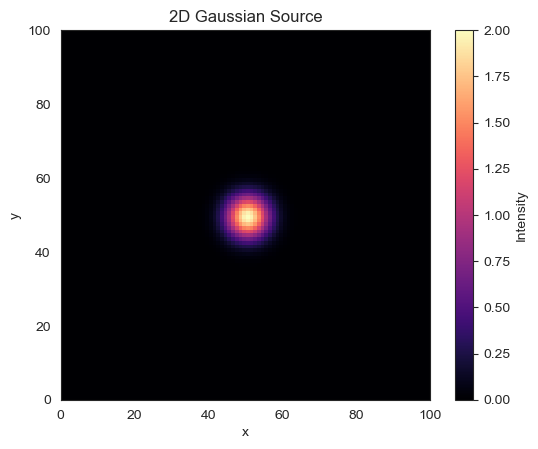

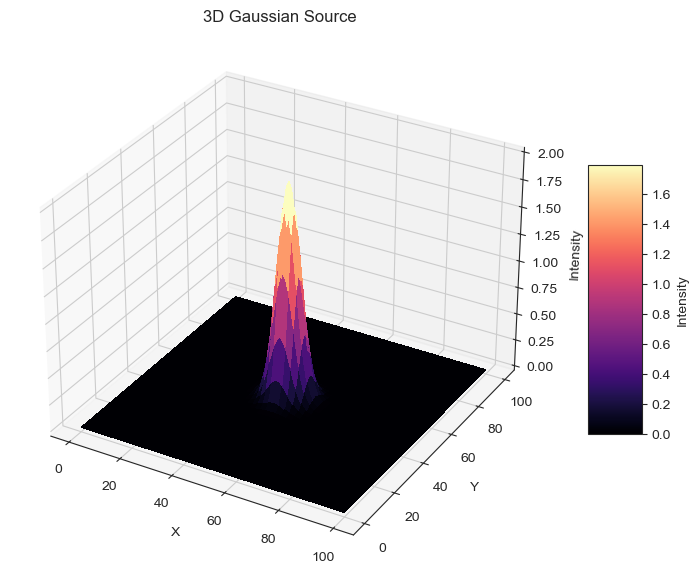

In [7]:
# Parameters
num_sources = 1000
grid_size = 100
sigma_range = (1, 10)
intensity_range = (1.0, 3) 

# Generate gaussian sources
gaussian_sources = generate_gaussian_sources(num_sources, grid_size, sigma_range, intensity_range)

# Create grid coordinates
x = np.linspace(0, grid_size, grid_size)
y = np.linspace(0, grid_size, grid_size)
x, y = np.meshgrid(x, y)

# Plot one of the souces
sns.set_style('white')
plt.imshow(gaussian_sources[0], extent=(0, grid_size, 0, grid_size), cmap='magma')
plt.colorbar(label='Intensity')
plt.title('2D Gaussian Source')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 3D Plot: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html#sphx-glr-gallery-mplot3d-surface3d-py 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface with colormap for the Gaussian source
surf = ax.plot_surface(x, y, gaussian_sources[0], cmap='magma', linewidth=0, antialiased=False)

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5, label = 'Intensity') 

# Set labels and title
plt.title('3D Gaussian Source')
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Intensity')
plt.show()


### Fourier Transformations + Incomplete Data

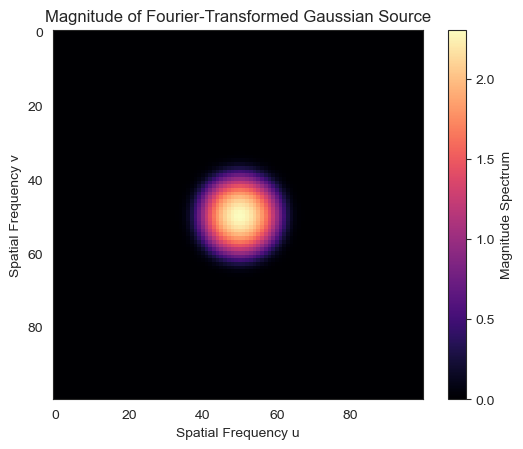

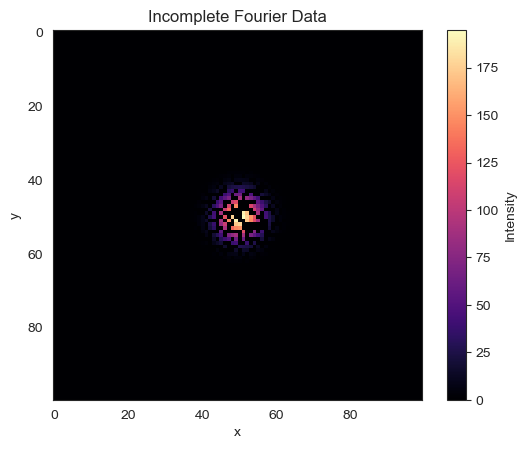

/var/folders/pq/xr8rr6kj661dlbhfxj5vw0z00000gn/T/ipykernel_11322/1511912643.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks()[::-1])


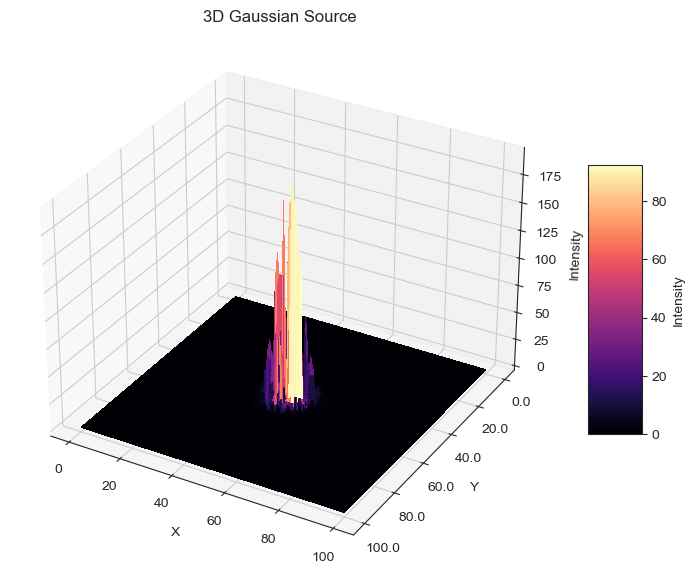

In [8]:
# Apply Fourier transform
magnitude, phase = apply_fourier_transform(gaussian_sources)

# Simulate incomplete sampling
sampling_rate = 0.5
incomplete_data, mask = incomplete_sampling(magnitude, sampling_rate)

# Plot Fourier magnitude
plt.imshow(np.log10(magnitude[0] + 1), cmap='magma')
plt.colorbar(label='Magnitude Spectrum')
plt.title('Magnitude of Fourier-Transformed Gaussian Source')
plt.xlabel('Spatial Frequency u')
plt.ylabel('Spatial Frequency v')
plt.show()

# Plot the incomplete data
plt.imshow(incomplete_data[0], cmap='magma')
plt.colorbar(label='Intensity')
plt.title('Incomplete Fourier Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 3D Plot: https://matplotlib.org/stable/gallery/mplot3d/surface3d.html#sphx-glr-gallery-mplot3d-surface3d-py 
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D surface with colormap for the Gaussian source
surf = ax.plot_surface(x, y, incomplete_data[0], cmap='magma', linewidth=0, antialiased=False)

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5, label = 'Intensity')

# Fix inversed y axis
ax.set_yticklabels(ax.get_yticks()[::-1]) 

# Set labels and title
plt.title('3D Gaussian Source')
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Intensity')
plt.show()


### CNN Training

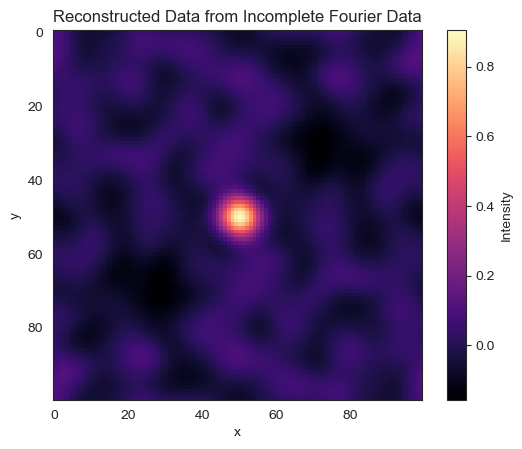

In [14]:
reconstructed_data = reconstruct_from_incomplete(incomplete_data, mask, phase)

# Plot the reconstructed data
plt.imshow(reconstructed_data[0], cmap='magma')
plt.colorbar(label='Intensity')
plt.title('Reconstructed Data from Incomplete Fourier Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


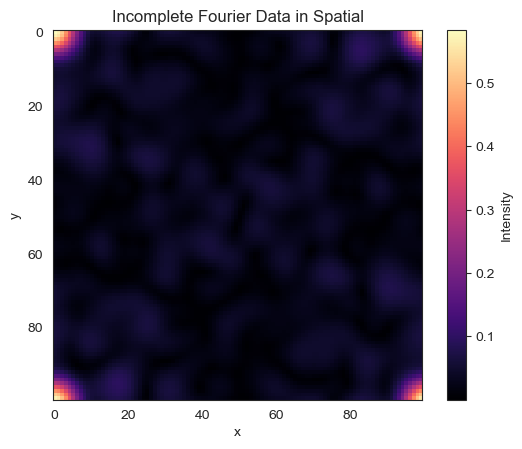

In [11]:
# Convert the incomplete fourier data back to the spatial domain
incomplete_data_real = np.abs(Discrete_Fourier_Transform.ifft2(Discrete_Fourier_Transform.ifftshift(incomplete_data, axes=(-2, -1))))

# Training data
X_train = incomplete_data_real[..., np.newaxis]
Y_train = gaussian_sources[..., np.newaxis]

# Plot the incomplete data
plt.imshow(incomplete_data_real[100], cmap='magma')
plt.colorbar(label='Intensity')
plt.title('Incomplete Fourier Data in Spatial')
plt.xlabel('x')
plt.ylabel('y')
plt.show()



In [10]:
# Model input shape (assuming channels-last format)
input_shape = (grid_size, grid_size, 1)

# Build and compile the model
cnn_model = build_cnn(input_shape)

# Train the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
history = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/50


/Users/bella/anaconda3/envs/gaussian_ENV/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


 1/25 ━━━━━━━━━━━━━━━━━━━━ 12s 504ms/step - loss: 0.2426

KeyboardInterrupt: 